In [58]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from numpy import mean, std
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score


READ DATASET


In [59]:
# Dict to store the model metrics like accuracy, f1, recall
metrics = {}

DATASET_PATH = "final-merged-dataset.csv"
df = pd.read_csv(DATASET_PATH)

# Initially set the clean_dataset as dataset itself. Using two variables clean_dataset
# and dataset to retain full dataset because after cleaning dataset we lose some data.
dataset = pd.read_csv(DATASET_PATH)
df

,Address A,Port A,Address B,Port B,Packets,Bytes,Packets A → B,Bytes A → B,Packets B → A,Bytes B → A,Rel Start,Duration,Bits/s A → B,Bits/s B → A,Target
0,68,255.255.255.255,67,1.0,364.0,1.0,364.0,0.0,0.0,3552.886318,0.000000,0.000000,0.000000,0.000000,NaN
1,50200,72.163.198.168,443,571362.0,461085075.0,242229.0,50039209.0,329133.0,411045866.0,0.000000,5498.082758,72809.684688,598093.385047,0.000000,NaN
2,62088,23.89.129.89,9000,270694.0,66375217.0,35027.0,5803218.0,235667.0,60571999.0,1572.531794,3589.891266,12932.353812,134983.473341,0.000000,NaN
3,55136,23.89.129.89,9000,7185.0,933693.0,3596.0,467468.0,3589.0,466225.0,1572.668468,3589.781698,1041.774769,1039.004684,0.000000,NaN
4,60143,23.89.129.89,9000,102354.0,45738988.0,9768.0,1013200.0,92586.0,44725788.0,1572.863216,3589.613124,2258.070639,99678.235966,0.000000,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6067,192.168.1.7,63919.0,34.149.43.113,443.0,29.0,9133.0,18.0,2394.0,11.0,6739.000000,14977.351270,112.948061,169.564664,477.316738,0.0
6068,192.168.1.7,63920.0,184.26.169.72,443.0,21.0,3153.0,10.0,1890.0,11.0,1263.000000,15071.377690,180.212772,83.900824,56.067058,0.0
6069,192.168.1.7,63921.0,20.44.229.112,443.0,120.0,74957.0,68.0,42680.0,52.0,32277.000000,15079.548760,180.737504,1889.148585,1428.679683,0.0
6070,192.168.1.7,63922.0,3.218.71.8,443.0,19.0,8424.0,10.0,1910.0,9.0,6514.000000,15253.367570,3.271286,4670.945922,15930.126560,0.0


Data Sepecfications


Total packets: 6072
0.0    3124
1.0    2363
Name: Target, dtype: int64


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-flow-classifer/quic/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


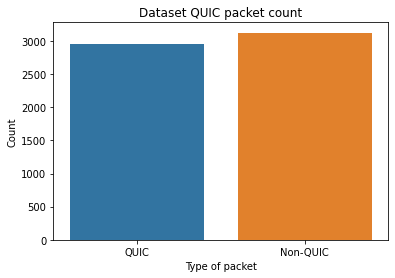

In [60]:
packet_protocol = df["Target"]
packet_protocol = ["QUIC" if x else "Non-QUIC" for x in packet_protocol]

print("Total packets: {0}".format(len(packet_protocol)))
print(df["Target"].value_counts())

chart = sns.countplot(packet_protocol)
plt.title("Dataset QUIC packet count")
plt.xlabel("Type of packet")
plt.ylabel("Count")
plt.show()


Data Pre-processing

In [61]:
def preprocess(df):
    # 1. Remove the strings columnns from dataset.
    df.drop(
        [
            "Address A",
            "Address B",
        ],
        axis=1,
        inplace=True,
    )

    # 2. Remove the invalid rows ie axis=0 from the dataset.
    df.dropna(axis=0, inplace=True)

    # 3. After deleting the rows, reset the index column and delete it.
    df.reset_index(drop=True)

    # 4. Get the result(quic) column values and remove dataset.
    targets = list(df["Target"].values)
    df.drop(df.columns[len(df.columns) - 1], axis=1, inplace=True)
    return df, targets

initial_size = dataset.size
df, targets = preprocess(df)
final_size = df.size

if df.isnull().values.any():
    print("Failed to clean dataset. There are NaN/null values in dataset.")
    nan_cols = [i for i in df.columns if df[i].isnull().any()]
    print("Columns with null values: ", *nan_cols)
    exit(1)


print(
    "\nDataset size: {0} = {1}, Cleaned dataset size: {2} = {3}, Clean percentage: {4}%".format(
        dataset.shape,
        initial_size,
        df.shape,
        final_size,
        round(100 - (final_size / initial_size) * 100, 2),
    )
)


Dataset size: (6072, 15) = 91080, Cleaned dataset size: (5487, 12) = 65844, Percentage: 27.71%


Split train and test


In [62]:
from sklearn.model_selection import KFold
from sklearn.datasets import make_classification

X_train, X_test, Y_train, Y_test = train_test_split(
    df, targets, test_size=0.30, random_state=7, shuffle=True
)

X, Y = make_classification(
    n_samples=100, n_features=12, n_informative=12, n_redundant=0, random_state=7
)
cv = KFold(n_splits=4, random_state=7, shuffle=True)
cv

print("Size of test: {0}, {1}".format(len(X_test), len(Y_test)))
print("Size of train: {0}, {1}".format(len(X_train), len(Y_train)))

Size of test: 1647, 1647
Size of train: 3840, 3840


LOGISTIC REGRESSION


In [63]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report

model = LogisticRegression(random_state=7)
clf = model.fit(X_train, Y_train)
predictions = clf.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100

print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))

metrics["LogisticRegression"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores)
}

              precision    recall  f1-score   support

         0.0       0.77      0.92      0.83       929
         1.0       0.85      0.64      0.73       718

    accuracy                           0.79      1647
   macro avg       0.81      0.78      0.78      1647
weighted avg       0.80      0.79      0.79      1647

Accuracy: 79.41712204007287%
f1-score: 72.94493216280925%
Accuracy: 63.64902506963789%
Precision: 85.42056074766356%


/Users/mutnawaz/Desktop/Muteeb/Projects/Paper/quic-flow-classifer/quic/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CV Accuracy: 85.000 (0.017)


DECISION TREE


In [64]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report

model = DecisionTreeClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100

print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["DecisionTree"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores),
}


              precision    recall  f1-score   support

         0.0       0.98      0.96      0.97       929
         1.0       0.95      0.97      0.96       718

    accuracy                           0.97      1647
   macro avg       0.97      0.97      0.97      1647
weighted avg       0.97      0.97      0.97      1647

Accuracy: 96.66059502125076%
f1-score: 96.20427881297448%
Accuracy: 97.07520891364902%
Precision: 95.34883720930233%
CV Accuracy: 68.000 (0.040)


GRADIENT BOOST


In [65]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

model = GradientBoostingClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100


print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["GradientBoost"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores)
}


              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       929
         1.0       0.96      0.97      0.97       718

    accuracy                           0.97      1647
   macro avg       0.97      0.97      0.97      1647
weighted avg       0.97      0.97      0.97      1647

Accuracy: 97.14632665452338%
f1-score: 96.75190048375951%
Accuracy: 97.49303621169916%
Precision: 96.02194787379973%
CV Accuracy: 76.000 (0.075)


KNN


In [66]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

model = KNeighborsClassifier()
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100



print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["KNN"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores)
}

              precision    recall  f1-score   support

         0.0       0.91      0.91      0.91       929
         1.0       0.88      0.88      0.88       718

    accuracy                           0.90      1647
   macro avg       0.90      0.90      0.90      1647
weighted avg       0.90      0.90      0.90      1647

Accuracy: 89.73891924711597%
f1-score: 88.22299651567945%
Accuracy: 88.16155988857939%
Precision: 88.28451882845188%
CV Accuracy: 87.000 (0.052)


RANDOM FOREST


In [67]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

model = RandomForestClassifier(random_state=0)
model.fit(X_train, Y_train)
predictions = model.predict(X_test)

print(classification_report(Y_test, predictions))

score = model.score(X_test, Y_test) * 100
f1 = f1_score(Y_test, predictions) * 100
recall = recall_score(Y_test, predictions) * 100
precision = precision_score(Y_test, predictions) * 100



print("Accuracy: {0}%".format(score))
print("f1-score: {0}%".format(f1))
print("Accuracy: {0}%".format(recall))
print("Precision: {0}%".format(precision))

scores = cross_val_score(model, X, Y, scoring="accuracy", cv=cv, n_jobs=-1)
print("CV Accuracy: %.3f (%.3f)" % (mean(scores) * 100, std(scores)))
metrics["RandomForest"] = {
    "Accuracy": score,
    "f1-score": f1,
    "Recall": recall,
    "Precision": precision,
    "CVAccuracy": mean(scores)
}

              precision    recall  f1-score   support

         0.0       0.98      0.97      0.97       929
         1.0       0.96      0.97      0.97       718

    accuracy                           0.97      1647
   macro avg       0.97      0.97      0.97      1647
weighted avg       0.97      0.97      0.97      1647

Accuracy: 97.02489374620522%
f1-score: 96.60899653979239%
Accuracy: 97.21448467966573%
Precision: 96.01100412654745%
CV Accuracy: 81.000 (0.077)


Feature importance for random forest


Port A           0.098918
Port B           0.002766
Packets          0.029078
Bytes            0.042766
Packets A → B    0.027595
Bytes A → B      0.137955
Packets B → A    0.036253
Bytes B → A      0.063161
Rel Start        0.047633
Duration         0.117926
Bits/s A → B     0.240329
Bits/s B → A     0.155621
dtype: float64


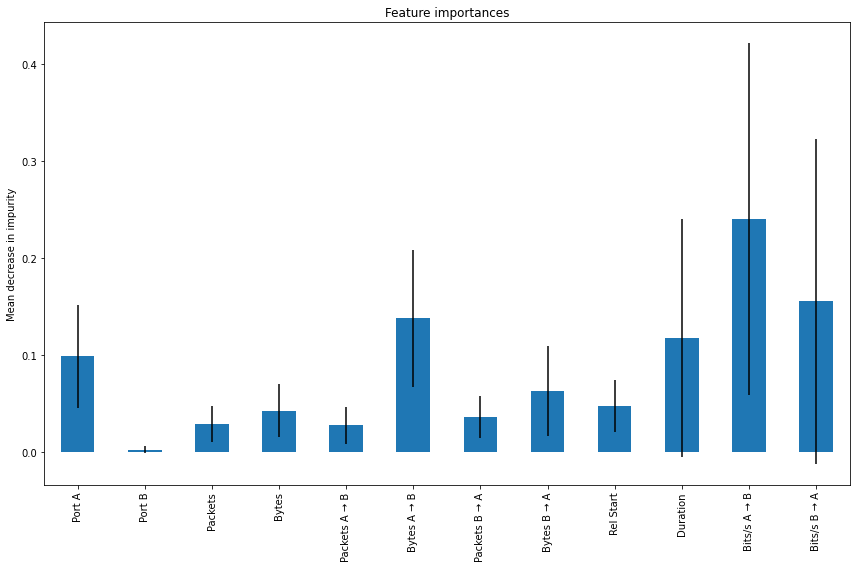

In [68]:
importances = model.feature_importances_
std = np.std([tree.feature_importances_ for tree in model.estimators_], axis=0)

features = list(df.columns)
classifier_importances = pd.Series(importances, index=features)
print(classifier_importances)

fig, ax = plt.subplots()
classifier_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout(rect=(0, 0, 2, 2))
plt.show()


ACCURACY


LogisticRegression                  79.41712204007287%
DecisionTree                        96.66059502125076%
GradientBoost                       97.14632665452338%
KNN                                 89.73891924711597%
RandomForest                        97.02489374620522%


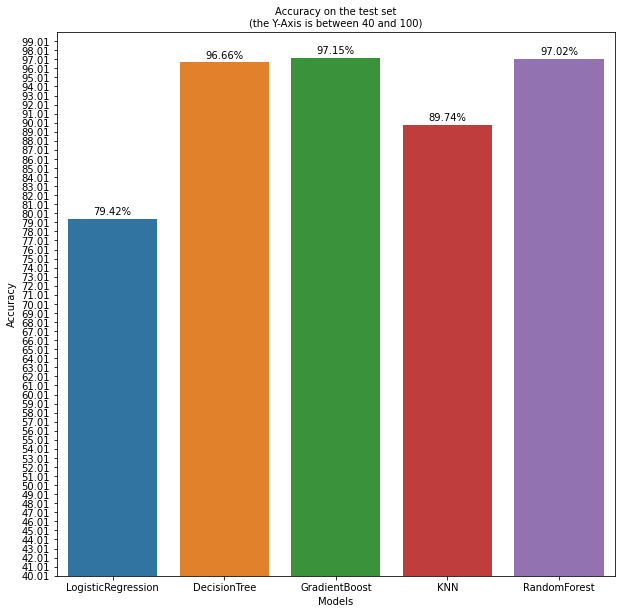

In [69]:
ticks = []
accuracy = []
models_accuracy = []

for k, v in metrics.items():
    accuracy.append(v["Accuracy"])
    models_accuracy.append(
        [k, v["Accuracy"], v["f1-score"], v["Recall"], v["Precision"]]
    )
    print("{0:<35} {1}%".format(k, v["Accuracy"]))

df_acc = pd.DataFrame(models_accuracy)
df_acc.columns = ["Models", "Accuracy", "f1-score", "Recall", "Precision"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="Accuracy", data=df_acc)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 40 and 100)", fontsize=10)
plt.ylim(40, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(accuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


LogisticRegression                  85.0%
DecisionTree                        68.0%
GradientBoost                       76.0%
KNN                                 87.0%
RandomForest                        81.0%


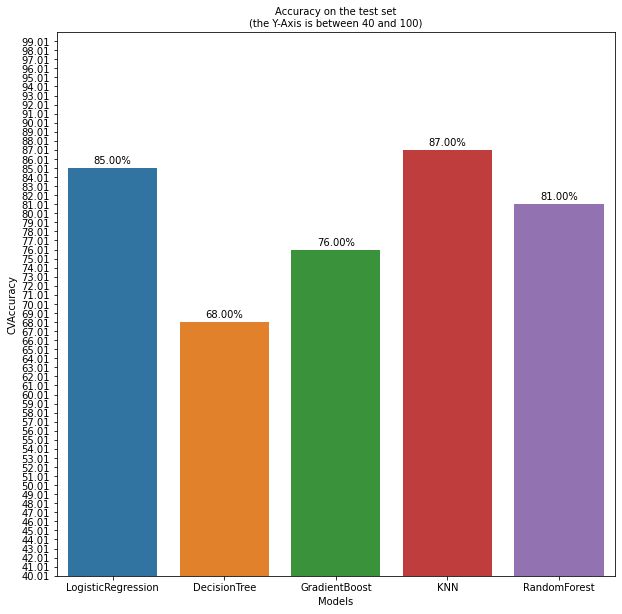

In [70]:
ticks = []
cvaccuracy = []
models_cvaccuracy = []
for k, v in metrics.items():
    try:
        cvaccuracy.append(v["CVAccuracy"] * 100)
        models_cvaccuracy.append([k, v["CVAccuracy"] * 100])
        print("{0:<35} {1}%".format(k, v["CVAccuracy"] * 100))

    except KeyError:
        cvaccuracy.append(10.30)
        models_cvaccuracy.append(10.30)
        print("{0:<35} {1}%".format(k, 1.03))
        continue


df_acc2 = pd.DataFrame(models_cvaccuracy)
df_acc2.columns = ["Models", "CVAccuracy"]

plt.figure(figsize=(10, 10))
g = sns.barplot(x="Models", y="CVAccuracy", data=df_acc2)
for i in range(0, 100):
    val = i + 0.01
    ticks.append(val)
g.set_yticks(ticks)
g.set_yticklabels(ticks)

plt.title("Accuracy on the test set\n(the Y-Axis is between 40 and 100)", fontsize=10)
plt.ylim(40, 100)
for i, p in enumerate(g.patches):
    percentage = "{:.2f}%".format(cvaccuracy[i])
    x = p.get_x() + (p.get_width() / 2)
    y = p.get_height() + 0.5
    g.annotate(percentage, (x, y), ha="center")

plt.show()


In [71]:
df_acc.head()


,Models,Accuracy,f1-score,Recall,Precision
0,LogisticRegression,79.417122,72.944932,63.649025,85.420561
1,DecisionTree,96.660595,96.204279,97.075209,95.348837
2,GradientBoost,97.146327,96.751900,97.493036,96.021948
3,KNN,89.738919,88.222997,88.161560,88.284519
4,RandomForest,97.024894,96.608997,97.214485,96.011004


<AxesSubplot:xlabel='Models'>

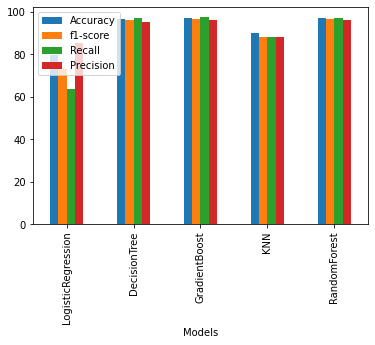

In [72]:
df_acc.plot(x="Models", y=["Accuracy", "f1-score", "Recall", "Precision"], kind="bar")


CNN


In [73]:
from tensorflow import keras
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D
from tensorflow.keras.layers import MaxPool1D
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense


In [74]:
from sklearn.preprocessing import OneHotEncoder

ohe = OneHotEncoder()
Y1 = np.array(targets).reshape(-1, 1)
Y1 = ohe.fit_transform(Y1).toarray()


In [75]:
X_train, X_test, Y_train, Y_test = train_test_split(
    df, Y1, test_size=0.20, random_state=7, shuffle=True
)


In [76]:
import tensorflow as tf

# tf.config.run_functions_eagerly(True)
# X_train = X_train
# X_train = X_train.values.reshape(-1,1,16)
X_train = np.expand_dims(X_train, axis=1)


def make_model(input_shape):
    # X_test=X_test.reshape(-1,1,16)
    # Y_test=Y_test.reshape(-1,2)

    input_layer = keras.layers.Input(input_shape)
    # X_test=X_test.reshape(-1,1,16)
    conv1 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(input_layer)
    conv1 = keras.layers.BatchNormalization()(conv1)
    conv1 = keras.layers.ReLU()(conv1)

    gap = keras.layers.GlobalAveragePooling1D()(conv1)
    conv2 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv1)
    conv2 = keras.layers.BatchNormalization()(conv2)
    conv2 = keras.layers.ReLU()(conv2)
    gap = keras.layers.GlobalAveragePooling1D()(conv2)
    conv3 = keras.layers.Conv1D(filters=64, kernel_size=3, padding="same")(conv2)
    conv3 = keras.layers.BatchNormalization()(conv3)
    conv3 = keras.layers.ReLU()(conv3)

    gap = keras.layers.GlobalAveragePooling1D()(conv3)

    output_layer = keras.layers.Dense(2, activation="sigmoid")(gap)

    return keras.models.Model(inputs=input_layer, outputs=output_layer)


model = make_model(input_shape=X_train.shape[1:])
tf.keras.utils.plot_model(model, show_shapes=True)


You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model/model_to_dot to work.


In [77]:
from tensorflow.keras.optimizers import SGD

opt = SGD(learning_rate=0.01)
model.compile(
    loss="categorical_crossentropy", optimizer=opt, metrics=["binary_accuracy"]
)


In [78]:
epochs = 100
batch_size = 32


In [79]:
Y_test = np.array(Y_test)


In [80]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.2,
    verbose=1,
)


ValueError: Failed to convert a NumPy array to a Tensor (Unsupported object type float).

In [ ]:
metric = "binary_accuracy"
plt.figure()
plt.plot(history.history[metric])
plt.plot(history.history["val_" + metric])
plt.title("model " + metric)
plt.ylabel(metric, fontsize="large")
plt.xlabel("epoch", fontsize="large")
plt.legend(["train", "val"], loc="best")
plt.show()
plt.close()


In [ ]:
Y_train = to_categorical(trainy)
Y_testy = to_categorical(testy)


In [ ]:
X_train.shape


In [ ]:
Y_train.shape


In [ ]:
n_timesteps, n_features, n_outputs = X_train.shape[0], X_train.shape[1], Y_train.shape[1]


In [ ]:
X_train = X_train.values.reshape(-1, 1, 12)


In [ ]:
model = Sequential()
model.add(Conv1D(filters=64, kernel_size=3, activation="relu", input_shape=(10, 128)))
model.add(Conv1D(filters=64, kernel_size=3, activation="relu"))
model.add(Dropout(0.5))
model.add(MaxPool1D(pool_size=2))
model.add(Flatten())
model.add(Dense(100, activation="relu"))
model.add(Dense(n_outputs, activation="softmax"))
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])


In [ ]:
verbose, epochs, batch_size = 0, 10, 32


In [ ]:
X_train.shape


In [ ]:
X_train = X_train.reshape(-1, 1, 12)


In [ ]:
model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size, verbose=verbose)


In [ ]:
model2 = Sequential()
model2.add(
    layers.Conv2D(32, (3, 3), activation="relu", input_shape=(8, 8, 1), padding="same")
)
model2.add(layers.MaxPooling2D((1, 1), padding="same"))
model2.add(layers.Conv2D(64, (3, 3), activation="relu", padding="same"))
model2.add(layers.MaxPooling2D((2, 2), padding="same"))
model2.add(layers.Conv2D(16, (3, 3), activation="softmax", padding="same"))
model2.add(layers.Flatten())
model2.add(layers.Dense(64, activation="relu"))
model2.add(layers.Dense(2))


In [ ]:
model2.summary()
